# Step One: Data Exploration

In [129]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder,label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve, 
    roc_auc_score
)

In [130]:
#Load dataset and display basic information
df = pd.read_csv("songs.csv", encoding="ISO-8859-1")

df.info() # Displays columns and types
df.head() # Displays first few columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


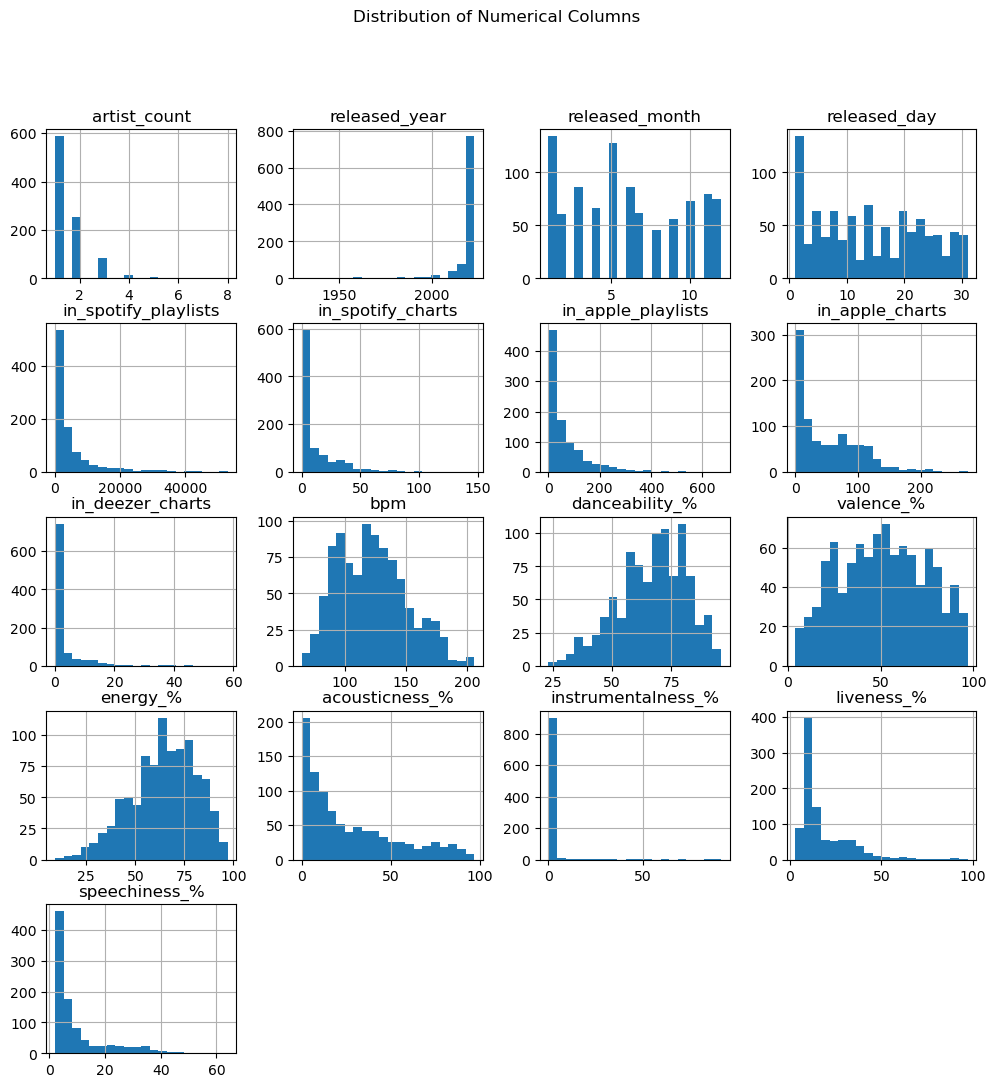

In [131]:
#Plot Data Distribution
numerical_cols = df.select_dtypes(include=['int64','float64']).columns
df[numerical_cols].hist(figsize = (12,12), bins = 20)
plt.suptitle("Distribution of Numerical Columns")
plt.show()

In [132]:
# Using to_numeric() method with downcasting, converting neumeric into integers
df['streams'] = pd.to_numeric(df['streams'], downcast='integer', errors='coerce')
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], downcast='integer', errors='coerce')
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'], downcast='integer', errors='coerce')

#Dropping empty columns
df = df.dropna()
cat_cols = ["key","mode"]
print("Categorical columns detected:")
print(cat_cols)

#Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(df[cat_cols])
# Convert encoded array back into a DataFrame with readable column names
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols))

# Drop original categorical columns from df and concatenate the encoded version
df_encoded = pd.concat([df.drop(columns=cat_cols).reset_index(drop=True),
                        encoded_df.reset_index(drop=True)], axis=1)
print(df_encoded.shape)
test_df = df_encoded
df_encoded = df_encoded.drop(columns=["track_name","artist(s)_name"])
df_encoded.head()

Categorical columns detected:
['key', 'mode']
(748, 35)


,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor
0,2,2023,7,14,553,147,141381703.0,43,263,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2023,3,23,1474,48,133716286.0,48,126,58.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2023,6,30,1397,113,140003974.0,94,207,91.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1,2019,8,23,7858,100,800840817.0,116,207,125.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,2023,5,18,3133,50,303236322.0,84,133,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


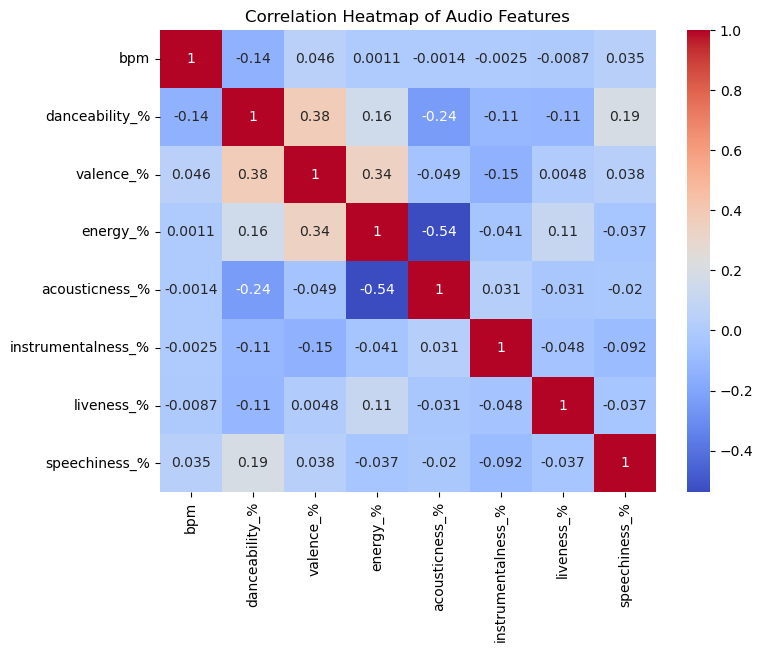

In [133]:
#Assess correlation of numerical features
numeric_features = ['bpm', 'danceability_%', 'valence_%', 'energy_%',
                    'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

corr = df[numeric_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Audio Features")
plt.show()

# Phase Two: Classification Model

In [134]:
#Separate target variables into percentage categories
TARGET = 'energy_%'
bins = [0,25,50,75,100]
target_classes = pd.cut(df_encoded[TARGET],bins,labels=["25%","50%","75%","100%"])
print(target_classes)


0      100%
1       75%
2       75%
3       75%
4      100%
       ... 
743     50%
744     25%
745     75%
746    100%
747     75%
Name: energy_%, Length: 748, dtype: category
Categories (4, object): ['25%' < '50%' < '75%' < '100%']


In [135]:
#Define X and y variables
X = df_encoded.drop(columns=[TARGET])
y_c = target_classes
y_r = df[TARGET]

#Split X and y into train and temporary sets
X_train_c, X_temp_c, y_train_c, y_temp_c = train_test_split(
    X,y_c,train_size=.70,random_state=42)

#Take temp set and split into validation and test sets (overall: 70% train, 20% validation, 10% test
X_val_c,X_test_c,y_val_c,y_test_c = train_test_split(
    X_temp_c,y_temp_c,train_size =(2/3),random_state=42)
print(X_train_c.shape)
print(X_val_c.shape)
print(X_test_c.shape)

#Initialize Logistic Regression model using pipelinining
cl_model = LogisticRegression(multi_class='auto',random_state=42)
cl_pipeline = Pipeline(
    steps=[
        ("scaler",StandardScaler()),
        ("model",model)
    ]
)
#Fit model
start = time.perf_counter()
cl_pipeline.fit(X_train,y_train)
end = time.perf_counter()
print(f'Training Time: {(end-start):,.2f} seconds')


(523, 32)
(150, 32)
(75, 32)
Training Time: 0.01 seconds


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Model Accuracy

In [136]:
#Calculate model performance
results = []
y_pred_c = cl_pipeline.predict(X_test_c)
acc_score = accuracy_score(y_test_c, y_pred_c)
pre_score = precision_score(y_test_c, y_pred_c,average="weighted",zero_division=0)
rec_score = recall_score(y_test_c,y_pred_c,average="weighted", zero_division=0)
f1 = f1_score(y_test_c,y_pred_c, average="weighted", zero_division=0)
cm = confusion_matrix(y_test_c,y_pred_c)
cm = confusion_matrix(y_test_c, y_pred_c)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_c, zero_division=0))

#
results.append({
    "Accuracy": acc_score,
    "Precision": pre_score,
    "Recall": rec_score,
    "F1-score": f1
})

#Display results
results_df = pd.DataFrame(results)
display(results_df)

Confusion Matrix:
[[ 7  1  9]
 [ 0  6  7]
 [ 5  3 37]]

Classification Report:
              precision    recall  f1-score   support

        100%       0.58      0.41      0.48        17
         50%       0.60      0.46      0.52        13
         75%       0.70      0.82      0.76        45

    accuracy                           0.67        75
   macro avg       0.63      0.57      0.59        75
weighted avg       0.66      0.67      0.65        75



,Accuracy,Precision,Recall,F1-score
0,0.666667,0.65509,0.666667,0.652921


(75, 4)
(75, 4)


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


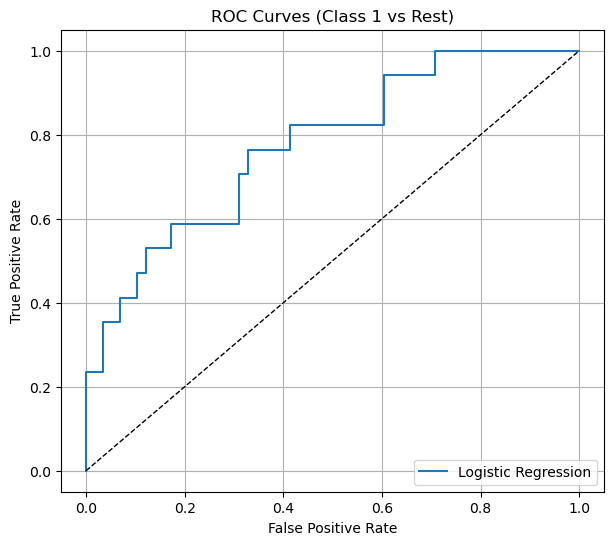

{'Model': 'Logistic Regression', 'AUC (macro OvR)': np.float64(nan)}


In [137]:
#Sort the values of the test set
classes = cl_pipeline.classes_
y_test_bin = label_binarize(y_test_c,classes=classes)
roc_data = {}
auc_results = []
y_prob = pipeline.predict_proba(X_test)

print(y_prob.shape)
print(y_test_bin.shape)
class_index = 1 if 1 in classes else 0
fpr, tpr, _ = roc_curve(y_test_bin[:, class_index], y_prob[:, class_index])
roc_data["Logistic Regression"] = (fpr, tpr)
auc_macro = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
auc_results = {"Model": "Logistic Regression", "AUC (macro OvR)": auc_macro}

#Plot the ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Class 1 vs Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#Display AUC results
print(auc_results)


## Recommendation Algorithm

In [138]:
def compute_model_vectors_c(model, song_df, feature_cols):
    """Add a column 'model_vec' with model outputs for each song."""
    vectors = model.predict_proba(song_df[feature_cols].values)
    song_df = song_df.copy()
    song_df["model_vec"] = list(vectors)
    song_df["track_name"] = test_df['track_name']
    song_df['artist(s)_name'] = test_df['artist(s)_name']
    return song_df

def recommend_similar_songs_classification(input_song_title, song_df, top_k=5):
    """Recommend songs by comparing class probability vectors."""
    if "model_vec" not in song_df.columns:
        raise ValueError("song_df must contain a 'model_vec' column from compute_model_prob_vectors().")

    if input_song_title.lower() not in song_df["track_name"].str.lower().values:
        raise ValueError(f"Song '{input_song_title}' not found in the song database.")

    # Extract vector for the input song
    input_vec = np.array(
        song_df.loc[song_df["track_name"] == input_song_title, "model_vec"].iloc[0]
    ).reshape(1, -1)
    print(input_vec.shape)
    # Stack vectors for similarity calculation
    all_vecs = np.vstack(song_df["model_vec"].values)
    print(all_vecs.shape)
    # Compute cosine similarity between probability vectors
    sims = cosine_similarity(input_vec, all_vecs)[0]
    song_df = song_df.copy()
    song_df["similarity"] = sims

    # Return top-k recommendations
    recs = (
        song_df[song_df["track_name"] != input_song_title]
        .sort_values("similarity", ascending=False)
        .head(top_k)
    )

    return recs[["track_name", "artist(s)_name", "similarity"]]

## Test Cases

In [139]:
vec = compute_model_vectors_c(cl_pipeline,df_encoded,df_encoded.drop(columns=[TARGET]).columns)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Test 1: Deja Vu - Olivia Rodrigo

In [140]:
print(recommend_similar_songs_classification("deja vu",vec))

(1, 4)
(748, 4)
                                 track_name              artist(s)_name  \
374  Snow On The Beach (feat. Lana Del Rey)  Taylor Swift, Lana Del Rey   
600                        Un Verano Sin Ti                   Bad Bunny   
358          Open Arms (feat. Travis Scott)           SZA, Travis Scott   
521                          Christmas Tree                           V   
709                                  Sparks                    Coldplay   

     similarity  
374    0.999519  
600    0.999458  
358    0.999342  
521    0.998889  
709    0.998691  


### Test 2: Sprinter - Dave

In [141]:
print(recommend_similar_songs_classification("Sprinter",vec))

(1, 4)
(748, 4)
                      track_name  \
135              POLARIS - Remix   
429  pushin P (feat. Young Thug)   
12                     Kill Bill   
190                     Curtains   
305            Jhoome Jo Pathaan   

                                        artist(s)_name  similarity  
135                         Feid, Mora, Saiko, Quevedo    0.999884  
429                          Young Thug, Future, Gunna    0.999740  
12                                                 SZA    0.999727  
190                                         Ed Sheeran    0.999723  
305  Arijit Singh, Vishal Dadlani, Sukriti Kakar, V...    0.999723  


### Test 3: Butter - BTS

In [142]:
print(recommend_similar_songs_classification("Butter",vec))

(1, 4)
(748, 4)
                  track_name                          artist(s)_name  \
497             City of Gods  Kanye West, Alicia Keys, Fivio Foreign   
68                  Fast Car                              Luke Combs   
633                     Iris                       The Goo Goo Dolls   
722  2 Be Loved (Am I Ready)                                   Lizzo   
83                     Bones                         Imagine Dragons   

     similarity  
497    0.999782  
68     0.999763  
633    0.999740  
722    0.999640  
83     0.999627  


# Step Three: Regression Model

In [143]:
X_train_r, X_temp_r, y_train_r, y_temp_r = train_test_split(
    X,y_r,train_size=.70,random_state=42)

#Take temp set and split into validation and test sets (overall: 70% train, 20% validation, 10% test
X_val_r,X_test_r,y_val_r,y_test_r = train_test_split(
    X_temp_r,y_temp_r,train_size =(2/3),random_state=42)
print(X_train_r.shape)
print(X_val_r.shape)
print(X_test_r.shape)
#Initialize Logistic Regression model using pipelinining
model2 = LogisticRegression(multi_class='auto',random_state=42)
reg_pipeline = Pipeline(
    steps=[
        ("scaler",StandardScaler()),
        ("model",model2)
    ]
)
#Fit model
start = time.perf_counter()
reg_pipeline.fit(X_train_r,y_train_r)
end = time.perf_counter()
print(f'Training Time: {(end-start):,.2f} seconds')

(523, 32)
(150, 32)
(75, 32)
Training Time: 0.03 seconds


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Model Accuracy

In [144]:
y_pred_r = reg_pipeline.predict(X_test_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2 = r2_score(y_test_r, y_pred_r)
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

RMSE: 15.21
R2: -0.06


## Recommendation Algorithm

In [145]:
def compute_model_vectors_r(model, song_df, feature_cols):
    """Add a column 'model_vec' with model outputs for each song."""
    vectors = model.predict(song_df[feature_cols])
    song_df = song_df.copy()
    song_df["model_vec"] = list(vectors)
    song_df["model_vec"] = list(vectors)
    song_df["track_name"] = test_df['track_name']
    song_df['artist(s)_name'] = test_df['artist(s)_name']
    return song_df

def recommend_similar_songs_regression(input_song_title, song_df, top_k=5):
    """Recommend songs by comparing class probability vectors."""
    if "model_vec" not in song_df.columns:
        raise ValueError("song_df must contain a 'model_vec' column from compute_model_prob_vectors().")

    if input_song_title not in song_df["track_name"].values:
        raise ValueError(f"Song '{input_song_title}' not found in the song database.")

    # Extract vector for the input song
    input_vec = np.array(
        song_df.loc[song_df["track_name"] == input_song_title, "model_vec"].iloc[0]
    ).reshape(1, -1)
    print(input_vec.shape)
    # Stack vectors for similarity calculation
    all_vecs = np.vstack(song_df["model_vec"].values)
    print(all_vecs.shape)
    # Compute cosine similarity between probability vectors
    sims = cosine_similarity(input_vec, all_vecs)[0]
    song_df = song_df.copy()
    song_df["similarity"] = sims

    # Return top-k recommendations
    recs = (
        song_df[song_df["track_name"] != input_song_title]
        .sort_values("similarity", ascending=False)
        .head(top_k)
    )

    return recs[["track_name", "artist(s)_name", "similarity"]]

## Test Cases

In [146]:
vec_r = compute_model_vectors_r(reg_pipeline,df_encoded,df_encoded.drop(columns=[TARGET]).columns)

### Test 1: Deja Vu - Olivia Rodrigo

In [147]:
print(recommend_similar_songs_regression("deja vu",vec_r))

(1, 1)
(748, 1)
                                            track_name     artist(s)_name  \
0                  Seven (feat. Latto) (Explicit Ver.)   Latto, Jung Kook   
502  All For Us - from the HBO Original Series Euph...  Labrinth, Zendaya   
493                                             MAMIII   Karol G, Becky G   
494                     Stay Alive (Prod. SUGA of BTS)          Jung Kook   
495                                          Boyfriend       Dove Cameron   

     similarity  
0           1.0  
502         1.0  
493         1.0  
494         1.0  
495         1.0  


### Test 2: Sprinter - Dave

In [148]:
print(recommend_similar_songs_regression("Sprinter",vec_r))

(1, 1)
(748, 1)
                                            track_name     artist(s)_name  \
0                  Seven (feat. Latto) (Explicit Ver.)   Latto, Jung Kook   
502  All For Us - from the HBO Original Series Euph...  Labrinth, Zendaya   
493                                             MAMIII   Karol G, Becky G   
494                     Stay Alive (Prod. SUGA of BTS)          Jung Kook   
495                                          Boyfriend       Dove Cameron   

     similarity  
0           1.0  
502         1.0  
493         1.0  
494         1.0  
495         1.0  


### Test 3: Butter - BTS

In [149]:
print(recommend_similar_songs_regression("Butter",vec_r))

(1, 1)
(748, 1)
                                            track_name     artist(s)_name  \
0                  Seven (feat. Latto) (Explicit Ver.)   Latto, Jung Kook   
502  All For Us - from the HBO Original Series Euph...  Labrinth, Zendaya   
493                                             MAMIII   Karol G, Becky G   
494                     Stay Alive (Prod. SUGA of BTS)          Jung Kook   
495                                          Boyfriend       Dove Cameron   

     similarity  
0           1.0  
502         1.0  
493         1.0  
494         1.0  
495         1.0  
